# Flipkart Project — Ready notebook
This notebook includes EDA, feature engineering, modeling pipeline and saves final outputs to /Users/shivalimuthukumar/Desktop/. Run top-to-bottom.

In [21]:
conda install -c conda-forge "numpy<2.0" --yes

zsh:1: no such file or directory: 2.0

Note: you may need to restart the kernel to use updated packages.


In [22]:
!pip install -U scikit-learn imbalanced-learn --quiet

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style='whitegrid')
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib
import warnings
warnings.filterwarnings('ignore')
print('Imports ready.')

Imports ready.


In [24]:
# 1. Load dataset

df = pd.read_csv("/Users/shivalimuthukumar/Desktop/Customer_support_data.csv")

print("Rows, Columns:", df.shape)
display(df.head(3))
display(df.info())

Rows, Columns: (85907, 20)


,Unique id,channel_name,category,Sub-category,Customer Remarks,Order_id,order_date_time,Issue_reported at,issue_responded,Survey_response_Date,Customer_City,Product_category,Item_price,connected_handling_time,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,NaN,NaN,NaN,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,NaN,NaN,NaN,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01/08/2023 20:16,01/08/2023 20:38,01-Aug-23,NaN,NaN,NaN,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unique id                85907 non-null  object 
 1   channel_name             85907 non-null  object 
 2   category                 85907 non-null  object 
 3   Sub-category             85907 non-null  object 
 4   Customer Remarks         28742 non-null  object 
 5   Order_id                 67675 non-null  object 
 6   order_date_time          17214 non-null  object 
 7   Issue_reported at        85907 non-null  object 
 8   issue_responded          85907 non-null  object 
 9   Survey_response_Date     85907 non-null  object 
 10  Customer_City            17079 non-null  object 
 11  Product_category         17196 non-null  object 
 12  Item_price               17206 non-null  float64
 13  connected_handling_time  242 non-null    float64
 14  Agent_name            

None

In [25]:
# 2. Quick cleaning & type conversions
# Trim column names
df.columns = df.columns.str.strip()

# Show columns for quick reference
print("Columns:", list(df.columns))

# Common conversions
possible_date_cols = [c for c in df.columns if any(k in c.lower() for k in ['date', 'time', 'timestamp'])]
print("Possible datetime columns:", possible_date_cols)

# Convert recognized date/time columns to datetime
for c in possible_date_cols:
    try:
        df[c] = pd.to_datetime(df[c], errors='coerce')
    except Exception as e:
        print(f"Could not convert {c} to datetime:", e)

# Basic missing counts
missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing > 0].head(40))


Columns: ['Unique id', 'channel_name', 'category', 'Sub-category', 'Customer Remarks', 'Order_id', 'order_date_time', 'Issue_reported at', 'issue_responded', 'Survey_response_Date', 'Customer_City', 'Product_category', 'Item_price', 'connected_handling_time', 'Agent_name', 'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift', 'CSAT Score']
Possible datetime columns: ['order_date_time', 'Survey_response_Date', 'connected_handling_time']


connected_handling_time    85665
Customer_City              68828
Product_category           68711
Item_price                 68701
order_date_time            68693
Customer Remarks           57165
Order_id                   18232
dtype: int64

Target column: CSAT Score


CSAT Score
1    11230
2     1283
3     2558
4    11219
5    59617
Name: count, dtype: int64

Numeric columns: ['Item_price', 'CSAT Score']


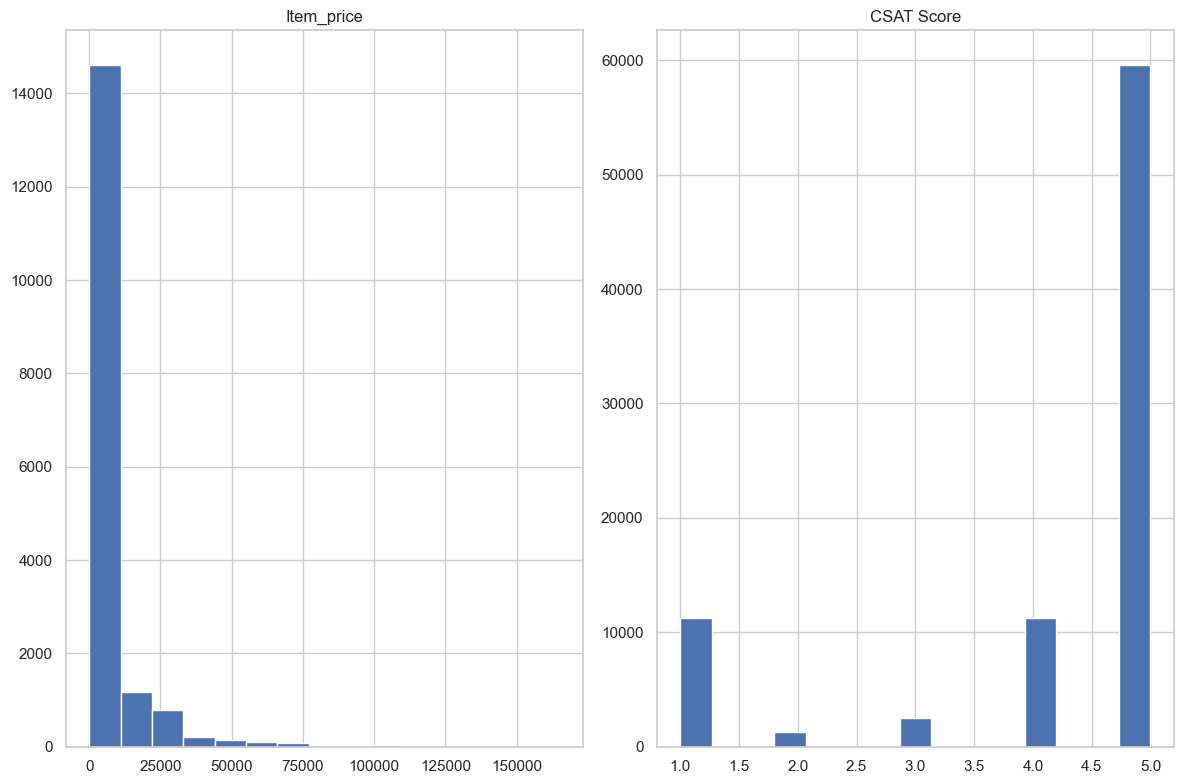

Categorical columns example counts:
--- Unique id ---
Unique id
7e9ae164-6a8b-4521-a2d4-58f7c9fff13f    1
4a7fec30-68f5-4891-b934-6a666e00930e    1
67792991-fd16-465f-bbdc-3189a0f16395    1
c629cb55-3c2b-448c-8598-96eeb0f30f13    1
67f2636b-055f-4ae5-a360-c3f35c09205c    1
c382055a-079b-4fbc-9390-c0e8310219d9    1
9e7bb01a-df3b-401d-8d25-197ed437e5cb    1
465b0fb0-99c0-4bbc-87d0-4bb73c281337    1
b7957c1f-6f86-41da-bda6-845b7f1cf611    1
e78186b5-b3fe-440d-86ca-b2da6d3773d1    1
Name: count, dtype: int64

--- channel_name ---
channel_name
Inbound    68142
Outcall    14742
Email       3023
Name: count, dtype: int64

--- category ---
category
Returns              44097
Order Related        23215
Refund Related        4550
Product Queries       3692
Shopzilla Related     2792
Payments related      2327
Feedback              2294
Cancellation          2212
Offers & Cashback      480
Others                  99
Name: count, dtype: int64

--- Sub-category ---
Sub-category
Reverse Pickup Enqui

In [26]:
# 3. EDA - distribution of target and important features
# 3.1 CSAT distribution (to find target column)
target_col = None
for candidate in ['CSAT Score', 'CSAT', 'CSAT_Score', 'CSATScore', 'csat score', 'csat']:
    if candidate in df.columns:
        target_col = candidate
        break

if target_col is None:
    # fallback: search numeric column that looks like CSAT
    for c in df.columns:
        if df[c].nunique() <= 6 and df[c].dtype in [np.int64, np.float64]:
            print("Candidate for target:", c, df[c].unique())
    raise ValueError("No obvious CSAT column found. Please ensure 'CSAT Score' column exists.")

print("Target column:", target_col)
display(df[target_col].value_counts(dropna=False).sort_index())

# 3.2 Basic distributions for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", num_cols)
df[num_cols].hist(bins=15, figsize=(12,8))
plt.tight_layout()
plt.show()

# 3.3 Top categorical value counts
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns example counts:")
for c in cat_cols[:8]:
    print(f"--- {c} ---")
    print(df[c].value_counts(dropna=False).head(10))
    print()


In [27]:
# Robust parsing + feature engineering (paste and run)
import re
from dateutil import parser
import numpy as np
import pandas as pd

# 1) Detect likely column names (safe, case-insensitive)
reported_col = None
responded_col = None
handling_col = None
for c in df.columns:
    lc = c.lower()
    if ('report' in lc or 'reported' in lc) and ('issue' in lc or 'report' in lc):
        reported_col = reported_col or c
    if 'respond' in lc or 'responded' in lc:
        responded_col = responded_col or c
    if 'handling' in lc or 'connected_handling' in lc or 'connected handling' in lc or 'handling_time' in lc:
        handling_col = handling_col or c

print("Detected columns:", "reported:", reported_col, "responded:", responded_col, "handling:", handling_col)

# 2) Convert a Series to datetime robustly
def safe_to_datetime(series):
    s = pd.to_datetime(series, errors='coerce', infer_datetime_format=True)
    if s.isna().mean() > 0.10:
        # try cleaning some common artifacts then re-parse
        cleaned = series.astype(str).str.strip().replace({'': None, 'nan': None})
        cleaned = cleaned.str.replace(r'\.0$', '', regex=True)
        s2 = pd.to_datetime(cleaned, errors='coerce', infer_datetime_format=True)
        s = s.fillna(s2)
    # final fallback to python-dateutil row-wise (slower)
    if s.isna().any():
        def try_parse(x):
            if pd.isna(x): 
                return pd.NaT
            try:
                return parser.parse(str(x))
            except Exception:
                return pd.NaT
        mask = s.isna()
        if mask.any():
            s.loc[mask] = series[mask].apply(try_parse)
    return s

# 3) Parse reported/responded if present
if reported_col:
    df[reported_col + "_parsed"] = safe_to_datetime(df[reported_col])
    print(f"{reported_col} parsed: {df[reported_col + '_parsed'].notna().sum()} non-null out of {len(df)}")
if responded_col:
    df[responded_col + "_parsed"] = safe_to_datetime(df[responded_col])
    print(f"{responded_col} parsed: {df[responded_col + '_parsed'].notna().sum()} non-null out of {len(df)}")

# 4) Compute response time in minutes when both parsed columns exist
rep_par = reported_col + "_parsed" if reported_col else None
resp_par = responded_col + "_parsed" if responded_col else None
if rep_par in df.columns and resp_par in df.columns:
    df['response_time_mins'] = (df[resp_par] - df[rep_par]).dt.total_seconds() / 60.0
    print("response_time_mins non-null:", df['response_time_mins'].notna().sum())
else:
    df['response_time_mins'] = np.nan
    print("response_time_mins set to NaN (missing parsed columns).")

# 5) Parse handling duration to minutes (accepts HH:MM:SS, MM:SS, numeric seconds, or strings)
def parse_duration_minutes(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.integer, np.floating)) and not isinstance(x, bool):
        return float(x) / 60.0
    s = str(x).strip()
    # keep digits and colons only
    s_clean = re.sub(r'[^\d:.-]', '', s)
    if ':' in s_clean:
        parts = [p for p in s_clean.split(':') if p!='']
        try:
            parts = [float(p) for p in parts]
        except:
            return np.nan
        if len(parts) == 3:
            secs = parts[0]*3600 + parts[1]*60 + parts[2]
            return secs / 60.0
        if len(parts) == 2:
            secs = parts[0]*60 + parts[1]
            return secs / 60.0
        return np.nan
    if re.fullmatch(r'-?\d+(\.\d+)?', s_clean):
        try:
            secs = float(s_clean)
            return secs / 60.0
        except:
            return np.nan
    # fallback: extract first number and treat it as seconds
    nums = re.findall(r'\d+(\.\d+)?', s)
    if nums:
        try:
            return float(nums[0]) / 60.0
        except:
            return np.nan
    return np.nan

if handling_col:
    df['handling_time_mins'] = df[handling_col].apply(parse_duration_minutes)
    print("handling_time_mins non-null:", df['handling_time_mins'].notna().sum())
else:
    df['handling_time_mins'] = np.nan
    print("handling_time_mins set to NaN (no handling column found).")

# 6) Text features from remarks/feedback (simple and fast)
text_col = None
for c in df.columns:
    lc = c.lower()
    if 'remark' in lc or 'feedback' in lc or 'comment' in lc:
        text_col = c
        break
print("Detected text column:", text_col)

if text_col:
    df['remark_len'] = df[text_col].fillna("").astype(str).str.len()
    df['remark_word_count'] = df[text_col].fillna("").astype(str).str.split().apply(len)
    keywords = ['refund','return','late','delayed','broken','wrong','cancel','replacement','unsatisfied','not delivered','delay']
    for kw in keywords:
        df[f'kw_{kw.replace(" ","_")}'] = df[text_col].fillna("").astype(str).str.lower().str.contains(kw).astype(int)
else:
    df['remark_len'] = np.nan
    df['remark_word_count'] = np.nan

# 7) Price and tenure parsing (coerce numbers)
price_col = None
for c in df.columns:
    if 'price' in c.lower() or 'item price' in c.lower() or 'item_price' in c.lower():
        price_col = price_col or c
if price_col:
    df['item_price'] = pd.to_numeric(df[price_col].astype(str).str.replace('[^\d\.\-]', '', regex=True), errors='coerce')
    print("item_price non-null:", df['item_price'].notna().sum())
else:
    df['item_price'] = np.nan

tenure_col = None
for c in df.columns:
    if 'tenure' in c.lower():
        tenure_col = tenure_col or c
if tenure_col:
    def parse_tenure(x):
        try:
            s = str(x)
            if '-' in s:
                a,b = re.findall(r'\d+(\.\d+)?', s)[:2]
                return (float(a) + float(b)) / 2.0
            nums = re.findall(r'\d+(\.\d+)?', s)
            if nums:
                return float(nums[0])
            return np.nan
        except:
            return np.nan
    df['tenure_months'] = df[tenure_col].apply(parse_tenure)
    print("tenure_months non-null:", df['tenure_months'].notna().sum())
else:
    df['tenure_months'] = np.nan

# 8) Show sample of engineered features for quick sanity check
show_cols = []
if rep_par in df.columns: show_cols.append(rep_par)
if resp_par in df.columns: show_cols.append(resp_par)
show_cols += ['response_time_mins','handling_time_mins','remark_len','remark_word_count','item_price','tenure_months']
show_cols = [c for c in show_cols if c in df.columns]
print("\nSample of engineered features (first 8 rows):")
display(df[show_cols].head(8))


Detected columns: reported: Issue_reported at responded: issue_responded handling: connected_handling_time
Issue_reported at parsed: 85907 non-null out of 85907
issue_responded parsed: 85907 non-null out of 85907
response_time_mins non-null: 85907
handling_time_mins non-null: 0
Detected text column: Customer Remarks
item_price non-null: 17206
tenure_months non-null: 0

Sample of engineered features (first 8 rows):


,Issue_reported at_parsed,issue_responded_parsed,response_time_mins,handling_time_mins,remark_len,remark_word_count,item_price,tenure_months
0,2023-01-08 11:13:00,2023-01-08 11:47:00,34.0,NaN,0,0,NaN,NaN
1,2023-01-08 12:52:00,2023-01-08 12:54:00,2.0,NaN,0,0,NaN,NaN
2,2023-01-08 20:16:00,2023-01-08 20:38:00,22.0,NaN,0,0,NaN,NaN
3,2023-01-08 20:56:00,2023-01-08 21:16:00,20.0,NaN,0,0,NaN,NaN
4,2023-01-08 10:30:00,2023-01-08 10:32:00,2.0,NaN,0,0,NaN,NaN
5,2023-01-08 15:13:00,2023-01-08 18:39:00,206.0,NaN,0,0,NaN,NaN
6,2023-01-08 15:31:00,2023-01-08 23:52:00,501.0,NaN,0,0,NaN,NaN
7,2023-01-08 16:17:00,2023-01-08 16:23:00,6.0,NaN,9,2,NaN,NaN


In [28]:
# Sanity check after feature engineering
print("Target column check:")
possible_targets = [c for c in df.columns if 'csat' in c.lower() or 'satisfaction' in c.lower()]
if possible_targets:
    print("Detected potential CSAT columns:", possible_targets)
else:
    print("No obvious CSAT column found. Check dataset header manually.")

# Inspect target distribution if column found
target_col = possible_targets[0] if possible_targets else None
if target_col:
    print("\nCSAT value counts:")
    print(df[target_col].value_counts(dropna=False).sort_index())

# Check parsing results
print("\nDatetime & duration feature checks:")
for col in ['response_time_mins','handling_time_mins']:
    if col in df.columns:
        print(f"{col}: non-null = {df[col].notna().sum()}, mean = {df[col].mean():.2f}, median = {df[col].median():.2f}")
    else:
        print(f"{col} not found in df.")

# Check sample remarks
text_col = None
for c in df.columns:
    if 'remark' in c.lower() or 'feedback' in c.lower() or 'comment' in c.lower():
        text_col = c
        break

if text_col:
    print(f"\nSample customer remarks (non-empty from {text_col}):")
    display(df.loc[df[text_col].notna() & (df[text_col] != ''), [text_col]].head(5))
else:
    print("\nNo customer remarks column detected.")


Target column check:
Detected potential CSAT columns: ['CSAT Score']

CSAT value counts:
CSAT Score
1    11230
2     1283
3     2558
4    11219
5    59617
Name: count, dtype: int64

Datetime & duration feature checks:
response_time_mins: non-null = 85907, mean = 332.62, median = 5.00
handling_time_mins: non-null = 0, mean = nan, median = nan

Sample customer remarks (non-empty from Customer Remarks):


,Customer Remarks
7,Very good
8,Shopzilla app and it's all coustomer care serv...
11,Very bad
17,Something
19,All good


In [29]:
# Define binary target
# try common CSAT column names
target_candidates = ['CSAT Score','CSAT_Score','CSATScore','CSAT','csat score','csat','Customer Satisfaction','Satisfaction']
target_col = None
for c in target_candidates:
    if c in df.columns:
        target_col = c
        break
# fallback: pick numeric column with small unique values (1-5 typical)
if target_col is None:
    for c in df.select_dtypes(include=[np.number]).columns:
        if df[c].nunique() <= 6:
            target_col = c
            break

if target_col is None:
    raise ValueError("No CSAT-like column found. Please tell me the exact column name for CSAT.")

print("Using CSAT column:", target_col)
# Map to binary: satisfied if >=4 when numeric
if pd.api.types.is_numeric_dtype(df[target_col]):
    df['target'] = (df[target_col] >= 4).astype(int)
else:
    df['target'] = df[target_col].astype(str).str.lower().map(
        lambda x: 1 if x in ['satisfied','yes','positive','1','4','5','excellent'] else 0
    ).fillna(0).astype(int)

print("Target distribution:")
display(df['target'].value_counts())


Using CSAT column: CSAT Score
Target distribution:


target
1    70836
0    15071
Name: count, dtype: int64

In [30]:
# Missing summary and drop very-sparse columns
missing_frac = df.isna().mean().sort_values(ascending=False)
print("Columns with >50% missing (will be dropped):")
drop_cols = missing_frac[missing_frac > 0.5].index.tolist()
display(missing_frac[missing_frac > 0.5])
df = df.drop(columns=drop_cols)
print("Dropped columns:", drop_cols)

# update feature lists
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'target' in numeric_cols: numeric_cols.remove('target')
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Numeric features left:", numeric_cols)
print("Categorical features left (sample):", cat_cols[:10])

Columns with >50% missing (will be dropped):


handling_time_mins         1.000000
tenure_months              1.000000
connected_handling_time    0.997183
Customer_City              0.801192
Product_category           0.799830
Item_price                 0.799714
item_price                 0.799714
order_date_time            0.799621
Customer Remarks           0.665429
dtype: float64

Dropped columns: ['handling_time_mins', 'tenure_months', 'connected_handling_time', 'Customer_City', 'Product_category', 'Item_price', 'item_price', 'order_date_time', 'Customer Remarks']
Numeric features left: ['CSAT Score', 'response_time_mins', 'remark_len', 'remark_word_count', 'kw_refund', 'kw_return', 'kw_late', 'kw_delayed', 'kw_broken', 'kw_wrong', 'kw_cancel', 'kw_replacement', 'kw_unsatisfied', 'kw_not_delivered', 'kw_delay']
Categorical features left (sample): ['Unique id', 'channel_name', 'category', 'Sub-category', 'Order_id', 'Issue_reported at', 'issue_responded', 'Agent_name', 'Supervisor', 'Manager']


In [31]:
# Preprocessing pipeline setup
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Select numeric engineered features we created earlier
numeric_features = [c for c in ['response_time_mins','handling_time_mins','remark_len','remark_word_count','item_price','tenure_months'] if c in df.columns]

# Choose a handful of categorical columns likely to be useful (exists in data)
possible_cats = ['Channel name','Channel','Category','Sub-category','Product category','Customer city','Agent Shift','Agent name','Supervisor','Manager']
categorical_features = [c for c in possible_cats if c in df.columns]

# Split categorical features by cardinality
ohe_features = [c for c in categorical_features if df[c].nunique(dropna=True) <= 20]
ord_features = [c for c in categorical_features if df[c].nunique(dropna=True) > 20]

print("Numeric features:", numeric_features)
print("OneHot features (low-cardinality):", ohe_features)
print("Ordinal features (high-cardinality):", ord_features)

numeric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])
ohe_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
ord_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

transformers = []
if numeric_features:
    transformers.append(('num', numeric_transformer, numeric_features))
if ohe_features:
    transformers.append(('ohe', ohe_transformer, ohe_features))
if ord_features:
    transformers.append(('ord', ord_transformer, ord_features))

preprocessor = ColumnTransformer(transformers=transformers, remainder='drop', sparse_threshold=0)
print("Preprocessor configured.")

Numeric features: ['response_time_mins', 'remark_len', 'remark_word_count']
OneHot features (low-cardinality): ['Agent Shift', 'Manager']
Ordinal features (high-cardinality): ['Sub-category', 'Supervisor']
Preprocessor configured.


Train/test shapes: (68725, 7) (17182, 7)

Logistic Regression results:
              precision    recall  f1-score   support

           0     0.2650    0.4456    0.3324      3014
           1     0.8621    0.7372    0.7947     14168

    accuracy                         0.6860     17182
   macro avg     0.5636    0.5914    0.5636     17182
weighted avg     0.7573    0.6860    0.7136     17182

ROC AUC: 0.6266357764087561


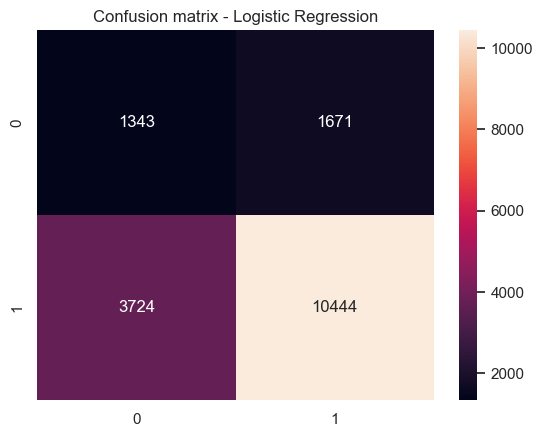


Random Forest results:
              precision    recall  f1-score   support

           0     0.3403    0.1997    0.2517      3014
           1     0.8435    0.9176    0.8790     14168

    accuracy                         0.7917     17182
   macro avg     0.5919    0.5587    0.5654     17182
weighted avg     0.7552    0.7917    0.7690     17182

ROC AUC: 0.6483454236900112


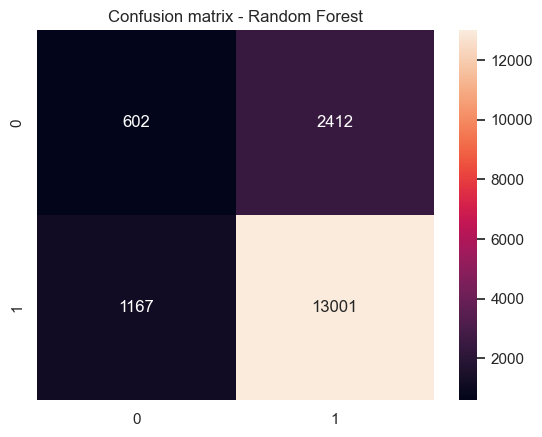

In [32]:
# Split data and run two baseline models

# Prepare X,y
feature_columns = numeric_features + ohe_features + ord_features
X = df[feature_columns].copy()
y = df['target'].copy()
# drop any rows where y is null
mask = y.notna()
X = X[mask]; y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
print("Train/test shapes:", X_train.shape, X_test.shape)
from sklearn.pipeline import Pipeline

def eval_pipeline(clf, name):
    pipeline = Pipeline(steps=[('pre', preprocessor), ('clf', clf)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    proba = pipeline.predict_proba(X_test)[:,1] if hasattr(pipeline.named_steps['clf'], "predict_proba") else None
    print(f"\n{name} results:")
    print(classification_report(y_test, y_pred, digits=4))
    if proba is not None:
        print("ROC AUC:", roc_auc_score(y_test, proba))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion matrix - {name}")
    plt.show()
    return pipeline

lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)

pipe_lr = eval_pipeline(lr, "Logistic Regression")
pipe_rf = eval_pipeline(rf, "Random Forest")

In [35]:
# Handle class imbalance (simple and clean)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# Convert data to processed arrays for SMOTE
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_trans, y_train)
print('Resampled training data shape:', X_res.shape)

# Retrain Random Forest on balanced data
rf_bal = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf_bal.fit(X_res, y_res)

# Evaluate on test set
y_pred_bal = rf_bal.predict(X_test_trans)
print('\nBalanced RF model results:')
print(classification_report(y_test, y_pred_bal, digits=4))

Resampled training data shape: (113336, 16)

Balanced RF model results:
              precision    recall  f1-score   support

           0     0.3402    0.3540    0.3470      3014
           1     0.8614    0.8540    0.8577     14168

    accuracy                         0.7663     17182
   macro avg     0.6008    0.6040    0.6023     17182
weighted avg     0.7700    0.7663    0.7681     17182



In [36]:
# Store baseline predictions for later comparison
y_pred = pipe_rf.predict(X_test)  # or pipe_lr if you want logistic as baseline
print("Stored baseline model predictions for comparison.")

Stored baseline model predictions for comparison.


In [37]:
# Compare baseline vs balanced model performance
from sklearn.metrics import classification_report
import pandas as pd

def get_metrics_dict(y_true, y_pred, label):
    rep = classification_report(y_true, y_pred, output_dict=True)
    return {
        "Model": label,
        "Accuracy": rep["accuracy"],
        "Precision_0": rep["0"]["precision"],
        "Recall_0": rep["0"]["recall"],
        "Precision_1": rep["1"]["precision"],
        "Recall_1": rep["1"]["recall"],
        "F1_macro": rep["macro avg"]["f1-score"]
    }

try:
    baseline_metrics = get_metrics_dict(y_test, y_pred, "Baseline")
    balanced_metrics = get_metrics_dict(y_test, y_pred_bal, "Balanced_SMOTE")
    df_compare = pd.DataFrame([baseline_metrics, balanced_metrics])
    display(df_compare)
except Exception as e:
    print("Could not compare models:", e)


,Model,Accuracy,Precision_0,Recall_0,Precision_1,Recall_1,F1_macro
0,Baseline,0.791701,0.340305,0.199735,0.843509,0.917631,0.565368
1,Balanced_SMOTE,0.766267,0.340242,0.354015,0.861384,0.853967,0.602326


In [38]:
# Small GridSearch for RandomForest
from sklearn.model_selection import GridSearchCV
rf_for_grid = RandomForestClassifier(random_state=42, class_weight='balanced')
pipe_grid = Pipeline([('pre', preprocessor), ('clf', rf_for_grid)])
param_grid = {'clf__n_estimators':[100,200], 'clf__max_depth':[None,10], 'clf__min_samples_split':[2,5]}
grid = GridSearchCV(pipe_grid, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print('Best params:', grid.best_params_)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print('\nBest model report:'); print(classification_report(y_test,y_pred,digits=4))


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/shivalimuthukumar/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shivalimuthukumar/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shivalimuthukumar/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shivalimuthukumar/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shivalimuthukumar/anaconda3/lib/python3.11/site-packages/

Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}

Best model report:
              precision    recall  f1-score   support

           0     0.3403    0.1997    0.2517      3014
           1     0.8435    0.9176    0.8790     14168

    accuracy                         0.7917     17182
   macro avg     0.5919    0.5587    0.5654     17182
weighted avg     0.7552    0.7917    0.7690     17182



In [39]:
# Save the final model
final_model = best_model if 'best_model' in globals() else pipe_rf
model_path = '/Users/shivalimuthukumar/Desktop/flipkart_final_model.joblib'
joblib.dump(final_model, model_path)
print('Saved model to', model_path)
test_out = X_test.copy(); test_out['y_true']=y_test; test_out['y_pred']=final_model.predict(X_test)
if hasattr(final_model.named_steps['clf'],'predict_proba'): test_out['y_proba']=final_model.predict_proba(X_test)[:,1]
test_out.to_csv("/Users/shivalimuthukumar/Desktop/test_predictions.csv", index=False)
print("Saved test predictions to /Users/shivalimuthukumar/Desktop/test_predictions.csv")

Saved model to /Users/shivalimuthukumar/Desktop/flipkart_final_model.joblib
Saved test predictions to /Users/shivalimuthukumar/Desktop/test_predictions.csv
